In [1]:
# Append web folder to system path
import sys
sys.path.append('../web')
from db_config import Base
from Database import Station, Availability, Weather
from sqlalchemy import create_engine, func, Column, String, Integer, Double, Boolean
from sqlalchemy.orm import sessionmaker
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('weather_availability_joined_all.csv')

In [3]:
# Convert station_id to int64
df['station_id'] = df['station_id'].astype('int64')

# Convert time_updated to datetime64
df['time_updated'] = pd.to_datetime(df['time_updated'])

# Convert available_bikes, available_bike_stands, and humidity to int64
df['available_bikes'] = df['available_bikes'].astype('int64')
df['available_bike_stands'] = df['available_bike_stands'].astype('int64')
df['humidity'] = df['humidity'].astype('int64')

# Convert temperature and wind_speed to float64
df['temperature'] = df['temperature'].astype('float64')
df['wind_speed'] = df['wind_speed'].astype('float64')

In [4]:
# One hot encode day of the week
df['weekday'] = df['time_updated'].dt.day_name()
df['hour'] = df['time_updated'].dt.hour
one_hot_encoded_days = pd.get_dummies(df['weekday'])
df['rain'] = df['type'] == 'Rain'

df = pd.concat([df, one_hot_encoded_days], axis=1)

df.drop('time_updated', axis = 1, inplace=True)
df.drop('weekday', axis = 1, inplace=True)
df.drop('Unnamed: 0', axis = 1, inplace=True)


df.head()

,Unnamed: 0.1,available_bikes,status,available_bike_stands,station_id,bike_stands,type,temperature,min_temp,humidity,...,sunset,hour,rain,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,2,OPEN,29,1,31,Clouds,11.91,11.53,81,...,1708451020,16,False,False,False,False,False,False,True,False
1,1,36,OPEN,4,90,40,Clouds,11.91,11.53,81,...,1708451020,16,False,False,False,False,False,False,True,False
2,2,10,OPEN,30,89,40,Clouds,11.91,11.53,81,...,1708451020,16,False,False,False,False,False,False,True,False
3,3,2,OPEN,28,88,30,Clouds,11.91,11.53,81,...,1708451020,16,False,False,False,False,False,False,True,False
4,4,5,OPEN,33,87,38,Clouds,11.91,11.53,81,...,1708451020,16,False,False,False,False,False,False,True,False


In [9]:
df.dtypes

available_bikes            int64
status                    object
available_bike_stands      int64
station_id                 int64
bike_stands                int64
type                      object
temperature              float64
min_temp                 float64
humidity                   int64
visibility                 int64
sunrise                    int64
feels_like               float64
description               object
max_temp                 float64
wind_speed               float64
clouds                     int64
sunset                     int64
hour                       int32
rain                        bool
Friday                      bool
Monday                      bool
Saturday                    bool
Sunday                      bool
Thursday                    bool
Tuesday                     bool
Wednesday                   bool
dtype: object

In [6]:
df.drop('Unnamed: 0.1', axis = 1, inplace=True)

In [26]:
df_onehot = pd.get_dummies(df)

,available_bikes,available_bike_stands,station_id,bike_stands,temperature,min_temp,humidity,visibility,sunrise,feels_like,...,description_heavy intensity rain,description_light intensity drizzle,description_light intensity drizzle rain,description_light intensity shower rain,description_light rain,description_mist,description_moderate rain,description_overcast clouds,description_scattered clouds,description_shower rain
0,2,29,1,31,11.91,11.53,81,10000,1708414464,11.27,...,False,False,False,False,False,False,False,False,False,False
1,36,4,90,40,11.91,11.53,81,10000,1708414464,11.27,...,False,False,False,False,False,False,False,False,False,False
2,10,30,89,40,11.91,11.53,81,10000,1708414464,11.27,...,False,False,False,False,False,False,False,False,False,False
3,2,28,88,30,11.91,11.53,81,10000,1708414464,11.27,...,False,False,False,False,False,False,False,False,False,False
4,5,33,87,38,11.91,11.53,81,10000,1708414464,11.27,...,False,False,False,False,False,False,False,False,False,False


In [28]:
grouped = df_onehot.groupby('station_id')

In [22]:
grouped = df[['station_id', 'temperature', 'min_temp', 'humidity', 'visibility', 'sunrise', 'max_temp', 'wind_speed', 'clouds', 'sunset', 'hour','rain', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'available_bikes']].groupby('station_id')

In [29]:
correlations = {}
for station_id, group in grouped:
    # Calculate correlations between 'available_bikes' and other columns
    station_correlation = group.corr()['available_bikes']
    for column, correlation in station_correlation.items():
        if column not in correlations:
            correlations[column] = []
        correlations[column].append(abs(correlation))


print(correlations)

{'available_bikes': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'available_bike_stands': [0.9998438266530274, 0.999828176206798, 0.9995565400237977, 0.9995080197693239, 0.9998711473357406, 0.7912835528785416, 0.9999520935956455, 0.9990565254028211, 0.999126095905113, 0.9983377306771092, 0.9996518187104603, 0.9982325245597484, 0.998807917290998, 0.9995648618656922, 0.9993992879785912, 0.9988289322737074, 0.9994078734739748, 0.999471521571337, 0.9994601193766369, 0.9998

In [30]:
for column, correlation_list in correlations.items():
    print(column, sum(correlation_list)/len(correlation_list))

available_bikes 1.0
available_bike_stands 0.9884276755783236
station_id nan
bike_stands nan
temperature 0.15187293668018628
min_temp 0.14654723072651873
humidity 0.1181356191971023
visibility 0.06091703949175576
sunrise 0.11870483667068757
feels_like 0.14298109724196603
max_temp 0.1537301877830978
wind_speed 0.10370949845394278
clouds 0.06592082299799064
sunset 0.11870468670059303
hour 0.08937230795411406
rain 0.06249146047749233
Friday 0.09316899312916982
Monday 0.09887332173018305
Saturday 0.1103062610476764
Sunday 0.14355314933860985
Thursday 0.09316263597873235
Tuesday 0.09173914485160468
Wednesday 0.08830624169976249
status_OPEN nan
type_Clear 0.062016940710642204
type_Clouds 0.061677415234233354
type_Drizzle 0.044178333898746945
type_Fog 0.03929937635296397
type_Mist 0.046449289128673785
type_Rain 0.06249146047749233
description_broken clouds 0.05408468544943776
description_clear sky 0.062016940710642204
description_drizzle 0.02374796767383305
description_few clouds 0.05991923562

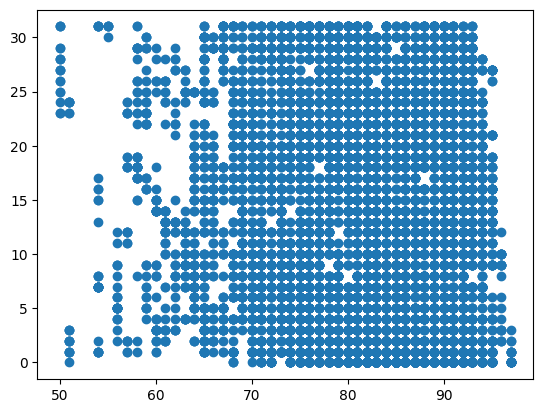

In [25]:
df_s1 = df[df['station_id'] == 1]
plt.scatter(df_s1['humidity'], df_s1['available_bikes'])